Reading network from 1684.edges
Network has 786 nodes and 14024 edges
Generating 100 random graphs...
Processing random graph 1/100
Processing random graph 11/100
Processing random graph 21/100
Processing random graph 31/100
Processing random graph 41/100
Processing random graph 51/100
Processing random graph 61/100
Processing random graph 71/100
Processing random graph 81/100
Processing random graph 91/100
Plot saved as 'degree_correlation_plot.png'
Network analysis suggests this is likely a assortative network

Summary:
Network type: assortative
Assortativity coefficient: 0.3298
Positive values indicate assortative mixing, negative values indicate disassortative mixing


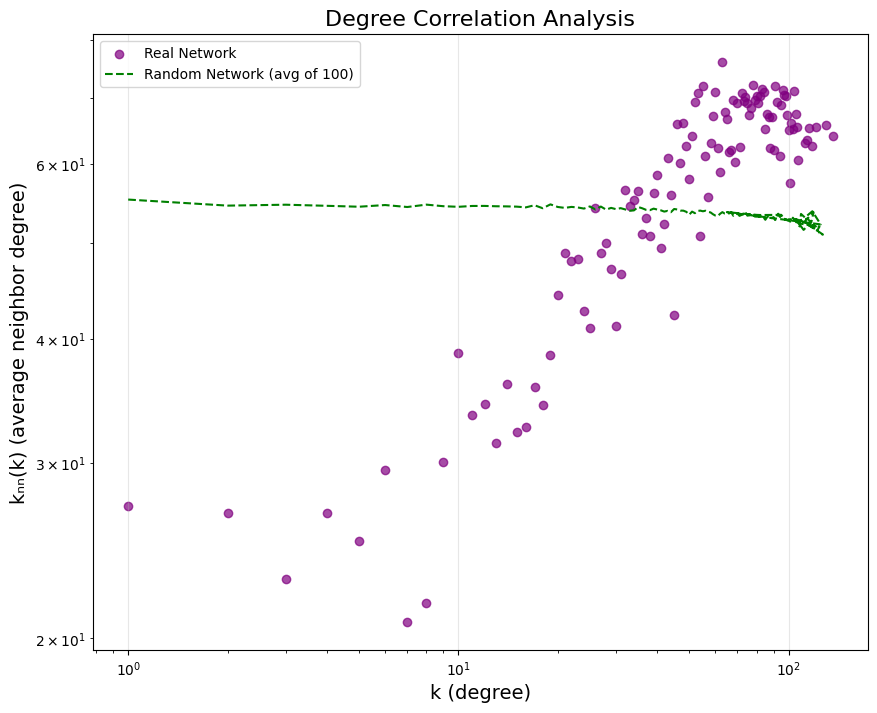

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from collections import defaultdict

# Step 1: Function to calculate k_nn(k)


def calKNN(G):
    # Initialize dictionary to store average neighbor degree for each degree k. This dict will hold the k_nn values. The knn is defined as the average degree of the neighbors of nodes with degree k.
    # The keys will be the degrees, and the values will be the average neighbor degree.
    knn_dict = {}

    all_degrees = dict(G.degree())
    degToNodes = defaultdict(list)
    for node, degree in all_degrees.items():
        degToNodes[degree].append(node)
    for k in sorted(degToNodes.keys()):
        nodes_with_degree_k = degToNodes[k]
        degNeigh = []
        for node in nodes_with_degree_k:
            neighbors = list(G.neighbors(node))
            if neighbors:
                avg_neighbor_degree = sum(
                    all_degrees[neighbor] for neighbor in neighbors) / len(neighbors)
                degNeigh.append(avg_neighbor_degree)

        if degNeigh:
            knn_dict[k] = sum(degNeigh) / len(degNeigh)

    return knn_dict


def randGraph(degSeq):
    try:
        G_random = nx.configuration_model(degSeq, seed=None)
        G_random = nx.Graph(G_random)
        return G_random
    except nx.NetworkXError:
        print("Failed to generate random graph with the given degree sequence")
        return None


def readFile(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                source = int(parts[0])
                target = int(parts[1])
                G.add_edge(source, target)

    return G

# function to compute the average neighbor degree for real network and for random networks creating 100 random networks with the same degree sequence as the real network. The function will also plot the results and save the plot as a PNG file. It will also determine if the network is assortative, disassortative or neutral based on the average neighbor degree for low and high degrees.
# The function will return a dictionary with the real network and random network data, and the type of network (assortative, disassortative or neutral).
def computing(edge_file, num_random_graphs=100):
    print(f"Reading network from {edge_file}")
    G_real = readFile(edge_file)
    num_nodes = G_real.number_of_nodes()
    num_edges = G_real.number_of_edges()
    print(f"Network has {num_nodes} nodes and {num_edges} edges")
    knn_real = calKNN(G_real)
    degree_sequence = [d for _, d in G_real.degree()]
    print(f"Generating {num_random_graphs} random graphs...")
    all_random_knn = defaultdict(list)

    for i in range(num_random_graphs):
        if i % 10 == 0:
            print(f"Processing random graph {i+1}/{num_random_graphs}")
        G_random = randGraph(degree_sequence)
        if G_random:
            knn_random = calKNN(G_random)
            for k, knn in knn_random.items():
                all_random_knn[k].append(knn)
    avg_random_knn = {}
    for k, values in all_random_knn.items():
        if values:
            avg_random_knn[k] = sum(values) / len(values)
    plt.figure(figsize=(10, 8))
    k_real = list(knn_real.keys())
    knn_real_values = list(knn_real.values())
    k_random = list(avg_random_knn.keys())
    knn_random_values = list(avg_random_knn.values())

    plt.scatter(k_real, knn_real_values, color='purple',alpha=0.7, label='Real Network')

    plt.plot(k_random, knn_random_values, 'g--',label='Random Network (avg of 100)')

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('k (degree)', fontsize=14)
    plt.ylabel('kₙₙ(k) (average neighbor degree)', fontsize=14)
    plt.title('Degree Correlation Analysis', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig('degree_correlation_plot.png', dpi=300, bbox_inches='tight')
    print("Plot saved as 'degree_correlation_plot.png'")

    network_type = "unknown"
    real_points = list(zip(k_real, knn_real_values))
    real_points.sort()
    if len(real_points) > 5:
        low_ks = real_points[:len(real_points)//2]
        high_ks = real_points[len(real_points)//2:]
        avg_low_knn = sum(knn for _, knn in low_ks) / len(low_ks)
        avg_high_knn = sum(knn for _, knn in high_ks) / len(high_ks)
        if avg_high_knn > avg_low_knn * 1.1:  # 10% of higher for high k will be marked as assortative
            network_type = "assortative"
        elif avg_high_knn < avg_low_knn * 0.9:  # 10% of lower for high k will be marked as disassortative
            network_type = "disassortative"
        else:
            network_type = "neutral"

    print(f"Network analysis suggests this is likely a {network_type} network")
    return {"real_network": {"k": k_real, "knn": knn_real_values},"random_network": {"k": k_random, "knn": knn_random_values},"network_type": network_type}


if __name__ == "__main__":

    edge_file = "1684.edges"
    if os.path.exists(edge_file):
        results = computing(edge_file)
        print("\nSummary:")
        print(f"Network type: {results['network_type']}")
        G = readFile(edge_file)
        r = nx.degree_assortativity_coefficient(G)
        print(f"Assortativity coefficient: {r:.4f}")
        print("Positive values indicate assortative mixing, negative values indicate disassortative mixing")
    else:
        print(f"Error: File '{edge_file}' not found.")
        print("Please make sure the edge file is in the correct location.")